In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
fileURL = './crime_data_latest.csv'
crime_data = pd.read_csv(fileURL, header=0)

In [18]:
crime_data = crime_data.fillna(0)
crime_data.head(15)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192053988,3410,Towed,TOWED MOTOR VEHICLE,D4,284,0,2019-07-13 19:12:00,2019,7,Saturday,19,Part Three,COLUMBUS AVE,0.000000,0.000000,"(0.00000000, 0.00000000)"
1,I192053980,3201,Property Lost,PROPERTY - LOST,B3,427,0,2019-07-13 21:00:00,2019,7,Saturday,21,Part Three,NORFOLK ST,42.276684,-71.092402,"(42.27668390, -71.09240248)"
2,I192053974,619,Larceny,LARCENY ALL OTHERS,A1,112,0,2019-07-13 20:24:00,2019,7,Saturday,20,Part One,WASHINGTON ST,42.354564,-71.061474,"(42.35456406, -71.06147418)"
3,I192053970,802,Simple Assault,ASSAULT SIMPLE - BATTERY,D4,165,0,2019-07-13 20:48:00,2019,7,Saturday,20,Part Two,ALBANY ST,42.342352,-71.062805,"(42.34235207, -71.06280467)"
4,I192053967,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,A7,26,0,2019-07-13 20:18:00,2019,7,Saturday,20,Part Three,MERIDIAN ST,42.379015,-71.039207,"(42.37901498, -71.03920664)"
5,I192053966,802,Simple Assault,ASSAULT SIMPLE - BATTERY,C6,915,0,2019-07-13 17:37:00,2019,7,Saturday,17,Part Two,COLUMBIA RD,42.330369,-71.048658,"(42.33036890, -71.04865770)"
6,I192053965,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,A7,9,0,2019-07-13 20:23:00,2019,7,Saturday,20,Part Three,FAYWOOD AVE,42.392146,-71.008939,"(42.39214603, -71.00893922)"
7,I192053964,2629,Harassment,HARASSMENT,C11,387,0,2019-07-13 20:11:00,2019,7,Saturday,20,Part Two,ADAMS ST,42.272306,-71.067214,"(42.27230624, -71.06721386)"
8,I192053963,3114,Investigate Property,INVESTIGATE PROPERTY,D4,131,0,2019-07-13 20:24:00,2019,7,Saturday,20,Part Three,BEACON ST,0.000000,0.000000,"(0.00000000, 0.00000000)"
9,I192053961,3008,Medical Assistance,SUICIDE / SUICIDE ATTEMPT,0,,0,2019-07-13 20:10:00,2019,7,Saturday,20,Part Three,ROWES,0.000000,0.000000,"(0.00000000, 0.00000000)"


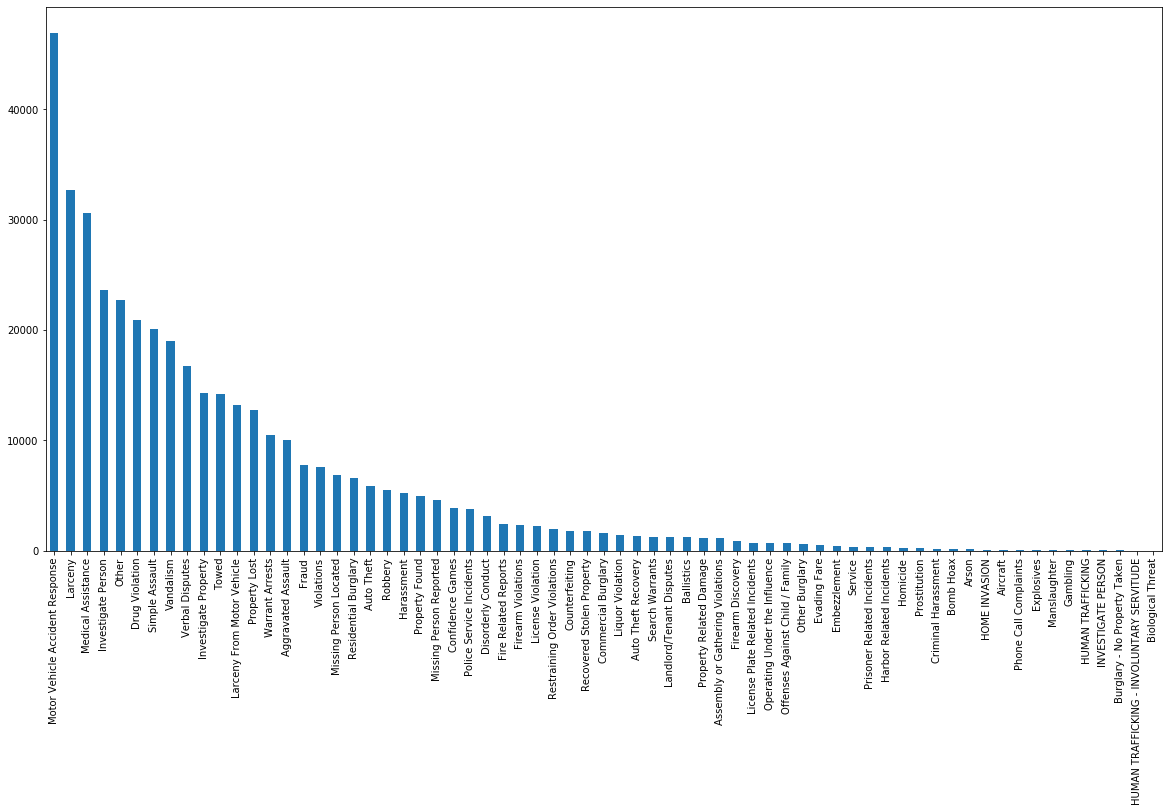

In [20]:
pd.value_counts(crime_data.OFFENSE_CODE_GROUP).plot.bar(figsize=(20,10))

In [26]:
pd.value_counts(crime_data.STREET).head(10).drop(0)

WASHINGTON ST        18273
BLUE HILL AVE         9956
BOYLSTON ST           9058
DORCHESTER AVE        6391
TREMONT ST            6174
MASSACHUSETTS AVE     5995
HARRISON AVE          5962
CENTRE ST             5591
COMMONWEALTH AVE      5245
Name: STREET, dtype: int64

In [27]:
pd.value_counts(crime_data.SHOOTING)

0    401530
Y      1639
Name: SHOOTING, dtype: int64